In [1]:
import sys
import itertools

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from statsmodels.regression.linear_model import OLS

sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [2]:
# reload helper and methods for when things change
reload(m);
reload(h);

### Reading Summary of Greedy Least Squares Paper
Paper: [Link](https://www.jmlr.org/papers/volume10/zhang09a/zhang09a.pdf)

#### Their setting: 
$$\mathbf{y} = X \overline{\beta} + z,$$
with $\mathbf{y} \in \mathbb{R}^n$, $X \in \mathbb{R}^{n \times d}$, $\overline{\beta} \in \mathbb{R}^d, z \in \mathbb{R}^n$.

#### Our setting: 
$$X_{t+1, \cdot} = X_{t, \cdot}W + z_{t+1}, \qquad t = 1, \ldots, T - 1.$$
with $\mathbf{X} \in \mathbb{R}^{p \times T}$, $W \in \mathbb{R}^{p \times p}$, $z_t \in \mathbb{R}^p$.

We can rewrite to $$\mathbf{y} = X w + z,$$
with $$\mathbf{y} = vec(X_{\cdot, 1}, X_{\cdot, 2}, \ldots, X_{\cdot, p}) \in \mathbb{R}^{p \cdot (T - 1)},$$
and $$\mathbf{X} = X_{\cdot, \cdot} \otimes I_p \in \mathbb{R}^{(p \cdot (T - 1) \times (p \cdot p)},$$ 
and $$w \in \mathbb{R}^{p \cdot p}.$$

*We see that we can cast our matrix setting into their vector setting*.

#### Their assumptions

*Assumption 1*. Assume that
- The basis functions are normalized such that $\frac{1}{n}\left\lVert \mathbf{x}_j\right\rVert_2^2 = 1$ for all $j = 1, \ldots, d$.
- The target function is truly sparse: there exists $\overline{\beta} \in \mathbb{R}^d$ with $\overline{F} = \text{supp}(\overline{\beta})$ such that $\mathbf{Ey} = X\overline{\beta}$.
- $\mu_X(\overline{F}) < 1$ and $\rho_X(\overline{F}) > 0$.
- $\mathbf{y} = [y_i]_{i=1,...,n}$ are independent (but not necessarily identically distributed) sub-Gaussians: there exists $s \geq 0$ such that $$\forall i \in \{1, \ldots, n\} \text{ and } \forall t \in \mathbb{R}: \quad \mathbf{E}_{y_i}e^{t(y_i−\mathbf{E}_{y_i})} \leq e^{\sigma^2t^2/2}$$.

Assumption 1.1: Our basis functions are _not_ normalized, but we can of course normalize them very easily.

Assumption 1.2: Our target function satisfies this by construction if we generate the data accordingly.

Assumption 1.3: Most likely yes, as long as our data generating matrix $W$ is not too strange.

Assumption 1.4: This is where things go *wrong*. Since our data is generated from a VAR(1) model, we will most definitely have *dependence* between different values $y_i$. Furthermore, the matter of subgaussianity needs to be investigated. However, if we generate our noise as a (sub)Gaussian, then we know that all our data will be (sub)Gaussian when we generate according to a VAR(1) model.

#### What we get then:
*Theorem 1.* Consider OMP, where Assumption 1 holds. Given any $\eta \in(0,0.5)$, with probability larger than $1-2 \eta$, if the stopping criterion satisfies $$\varepsilon>\frac{1}{1-\mu_{X}(F)} \sigma \sqrt{2 \ln (2 d / \eta)}, \quad \min _{j \in \overline{F}}\left|\bar{\beta}_{j}\right| \geq 3 \varepsilon \rho_{X}(\bar{F})^{-1} / \sqrt{n},$$
then when the procedure stops, we have $F^{(k-1)}=\bar{F}$ and
$$
\left\|\beta^{(k-1)}-\bar{\beta}\right\|_{\infty} \leq \sigma \sqrt{(2 \ln (2|\bar{F}| / \eta)) /\left(n \rho_{X}(\bar{F})\right)}.
$$

*Theorem 2*. Consider OMP, where Assumption 1 holds. Given any $\eta \in(0,0.5)$, with probability larger than $1-2 \eta$, if the stopping criterion satisfies $$\varepsilon>\frac{1}{1-\mu_{X}(F)} \sigma \sqrt{2 \ln (2 d / \eta)}$$
then when the procedure stops, the following claims are true:
- $F^{(k-1)} \subset \bar{F}$.
- $\left|\bar{F}-F^{(k-1)}\right| \leq 2\left|\left\{j \in \bar{F}:\left|\bar{\beta}_{j}\right|<3 \varepsilon \rho_{X}(\bar{F})^{-1} / \sqrt{n}\right\}\right|$
- $\left\|\beta^{(k-1)}-\hat{\beta}_{X}(\bar{F}, \mathbf{y})\right\|_{2} \leq \varepsilon \rho(\bar{F})^{-1} \sqrt{\left|\bar{F}-F^{(k-1)}\right| / n} .$
- $\left\|\hat{\beta}_{X}(\bar{F}, \mathbf{y})-\bar{\beta}\right\|_{\infty} \leq \sigma \sqrt{(2 \ln (2|\bar{F}| / \eta)) /\left(n \rho_{X}(\bar{F})\right)}$.

### Let us investigate whether this theorem holds _empirically_

All edges are either -0.25 or +0.25, and full rank
[[ 0.5 -0.6 -0.3]
 [ 0.   0.5  0. ]
 [ 0.   0.   0. ]]


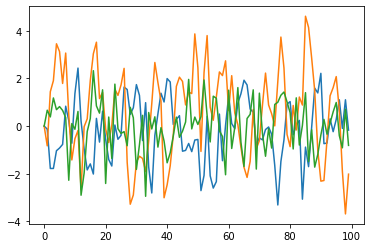

In [3]:
# first, let us gather some data and true W
load = True

# declare variables
W_true, X = None, None

if load:
    # Get data name
    data_name = "X_s4_n3_T100_random_matrix_1"

    # Load data
    W_true, X, expl = h.load_data(data_name)
    
    # Given explanation
    print(expl)

W_true = np.array([[0.5, -0.6, - 0.3], [0.0, 0.5, 0.0], [0.0, 0.0, 0.0]])
# W_true = 0.5 * np.diag(np.ones(3))
X = h.generate_var_2(100, 3, W_true, np.identity(3))
    
print(np.round(W_true, 2))
plt.plot(X);

T, n = np.shape(X)

1	[-0.56622831  0.          0.          0.        ]
2	[-0.34337845  0.          0.          0.        ]
5	[ 0.         -0.32618967  0.05313329  0.        ]
7	[ 0.          0.          0.         -0.56622831]
8	[ 0.          0.          0.         -0.34337845]
0.5662283136232483
1	[-0.86796143  0.          0.          0.        ]
2	[-0.35813913  0.          0.          0.        ]
5	[ 0.         -0.34021146  0.05541731  0.        ]
7	[ 0.          0.          0.         -0.86796143]
8	[ 0.          0.          0.         -0.35813913]
0.8679614332598282


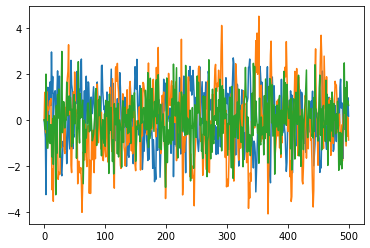

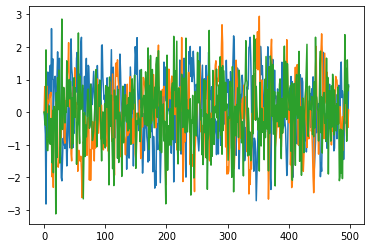

In [11]:
#n, T = 25, 50
#s = 50
# W_true = np.zeros((n, n))
# W_true[0][2] = 0.1
#W_true = h.generate_A(n, s, low = 0.25, high = 0.5)
# print(W_true)

# W_true = np.diag(0.9 * np.ones(n))
X = h.generate_var_2(T, n, W_true, np.identity(n))

plt.plot(X)

## Assumption 1.1
# first, we must normalize all data
norm_const_X = np.sqrt((X[:-1] ** 2).sum(axis=0) / T)
norm_const_Y = np.sqrt((X[1:] ** 2).sum(axis=0) / T)

# normalize X and Y
X_norm = X[:-1] / norm_const_X
Y_norm = X[1:] / norm_const_Y

# vectorize data
X_norm_vec = np.kron(np.eye(n, dtype=float), X_norm)
Y_norm_vec = np.kron(np.eye(n, dtype=float), Y_norm)

# check X_norm_vec
# for series in X_norm_vec.T:
#     print(np.linalg.norm(series, 2) ** 2)
#print(W_true)

X_vec = np.kron(np.eye(n, dtype=float), X[:-1])
Y_vec = np.kron(np.eye(n, dtype=float), X[1:])

print(mu(W_true, X_norm_vec, Y_norm_vec))
print(mu(W_true, X_norm_vec, Y_vec))
plt.show()
plt.plot(X_norm);

When there is *no* correlation, the estimates are very close to zero.

### Assumption 1.1
- The basis functions are normalized such that $\frac{1}{n}\left\lVert \mathbf{x}_j\right\rVert_2^2 = 1$ for all $j = 1, \ldots, d$.

In [12]:
T, n, s = 500, 3, 4
# W_true = 0.5 * np.diag(np.ones(n))
X = h.generate_var_2(T, n, W_true, np.identity(3))

## Assumption 1.1
# first, we must normalize all data
norm_const_X = np.sqrt((X[:-1] ** 2).sum(axis=0) / (n * (T - 1)))
norm_const_Y = np.sqrt((X[1:] ** 2).sum(axis=0) / (n * (T - 1)))

# normalize X and Y
X_norm = X[:-1] / norm_const_X
Y_norm = X[1:] / norm_const_Y

# vectorize data
X_norm_vec = np.kron(np.eye(n, dtype=float), X_norm)
Y_norm_vec = np.kron(np.eye(n, dtype=float), Y_norm)

X_vec = np.kron(np.eye(n, dtype=float), X[:-1])
Y_vec = np.kron(np.eye(n, dtype=float), X[1:])

# get dimensions
n_paper, d_paper = np.shape(X_norm_vec)

# consequently, the matrix W must also be "adjusted"
W_norm = W_true.T * norm_const_X
W_norm = W_norm.T / norm_const_X

print(mu(W_norm, X_norm_vec, Y_norm_vec))

# print normalized basis vectors
print(f"Normalized basis vectors: {[round(np.linalg.norm(X_norm_vec[:, i]) ** 2 / n_paper, 4) for i in range(d_paper)]}.\n")

# new W
print(f"New normalized W:\n{np.round(W_norm, 2)}.")

# restrict X only to non-zero entries; X_F_bar
X_F_bar = X_norm_vec[:, np.where(W_norm.T.flatten() != 0)[0]]
print(np.shape(X_F_bar))


1	[-0.58839634  0.          0.          0.        ]
2	[-0.3030319  0.         0.         0.       ]
5	[ 0.         -0.32862889 -0.09089068  0.        ]
7	[ 0.          0.          0.         -0.58839634]
8	[ 0.         0.         0.        -0.3030319]
0.588396344678306
Normalized basis vectors: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].

New normalized W:
[[ 0.5  -0.47 -0.35]
 [ 0.    0.5   0.  ]
 [ 0.    0.    0.  ]].
(1497, 4)


### Assumption 1.2
- The target function is truly sparse: there exists $\overline{\beta} \in \mathbb{R}^d$ with $\overline{F} = \text{supp}(\overline{\beta})$ such that $\mathbf{Ey} = X\overline{\beta}$.
In our setting, that means that the support of the true parameters constitues a DAG.

In [9]:
## Assumption 1.2
# the data generating matrix constitues a DAG
print(f"Is W a DAG: {h.is_dag(W_true)[0]}.")

Is W a DAG: True.


### Assumption 1.3
- $\mu_X(\overline{F}) < 1$ and $\rho_X(\overline{F}) > 0$.

Here, $$\mu_{X}(\bar{F})=\max _{j \notin \bar{F}} \left\lVert\left(X_{F}^{T} X_{\bar{F}}\right)^{-1} X_{\bar{F}}^{T} \mathbf{x}_{j} \right\rVert_{1},$$ and $$\rho_{X}(\bar{F})=\inf \left\{\frac{1}{n}\|X \beta\|_{2}^{2} /\|\beta\|_{2}^{2}: \operatorname{supp}(\beta) \subset \bar{F}\right\}$$

In [10]:
def mu(W, X, Y):
    """Computes this strange mu"""
    
    # restrict X only to non-zero entries; X_F_bar
    X_F_bar = X[:, np.where(W.T.flatten() != 0)[0]]
    
    # print([np.linalg.norm(OLS(Y[:, index], X_F_bar).fit().params, 1) for index in np.where(W.flatten() == 0)[0]])
    
    for index in np.where(W.T.flatten() == 0)[0]:
        # print(OLS(Y[:, index], X_F_bar).fit().params)
        print(index, end = "\t")
        print(np.linalg.inv(X_F_bar.T @ X_F_bar) @ X_F_bar.T @ Y[:, index])
    
    # return this mu
    return max([np.linalg.norm(OLS(Y[:, index], X_F_bar).fit().params, 1) for index in np.where(W.T.flatten() == 0)[0]])

print("W_normalized:\n", W_norm)
# print(mu(W_true, X_norm_vec, Y_norm_vec))
print(mu(W_true, X_norm_vec, Y_vec))

W_normalized:
 [[ 0.5        -0.43227656 -0.31079029]
 [ 0.          0.5         0.        ]
 [ 0.          0.          0.        ]]
1	[-0.88743583  0.          0.          0.        ]
2	[-0.30447033  0.          0.          0.        ]
5	[ 0.         -0.30203279  0.00747652  0.        ]
7	[ 0.          0.          0.         -0.88743583]
8	[ 0.          0.          0.         -0.30447033]
0.8874358316185247


In [13]:
def rho(W, X):
    """Compute rho"""
    
    # restrict X only to zero entries; X_F_bar
    X_F_bar = X[:, np.where(W.flatten() != 0)[0]]
    
    # compute restricted design matrix 1 / n_paper X_F_bar.T @ X_F_bar
    design_matrix = X_F_bar.T @ X_F_bar / n_paper
    
    # compute rho   
    return min(np.linalg.eig(design_matrix)[0])
    
round(rho(W_norm, X_norm_vec), 5)

0.7124

In [14]:
## Assumption 1.3
# need to compute strange mu(F) 
print(f"Mu:  Should be < 1: {round(mu(W_norm, X_norm_vec, Y_norm_vec), 5)}.")

# need to compute rho(F)
print(f"Rho: Should be > 0: {round(rho(W_norm, X_norm_vec), 5)}.")

1	[-0.58839634  0.          0.          0.        ]
2	[-0.3030319  0.         0.         0.       ]
5	[ 0.         -0.32862889 -0.09089068  0.        ]
7	[ 0.          0.          0.         -0.58839634]
8	[ 0.         0.         0.        -0.3030319]
Mu:  Should be < 1: 0.5884.
Rho: Should be > 0: 0.7124.


### Assumption 1.4
- $\mathbf{y} = [y_i]_{i=1,...,n}$ are independent (but not necessarily identically distributed) sub-Gaussians: there exists $\sigma \geq 0$ such that $$\forall i \in \{1, \ldots, n\} \text{ and } \forall t \in \mathbb{R}: \quad \mathbf{E}_{y_i}e^{t(y_i−\mathbf{E}_{y_i})} \leq e^{\sigma^2t^2/2}.$$
Our $y_i$ are Gaussian, and then the standard deviation of the $y_i$ is a valid $\sigma$ here, but what is this standard deviation? 

In [15]:
sigma = np.sqrt(max(np.diag(np.cov(X_norm.T))))
print(f"Maximum covariance of all normalized y: {round(sigma, 4)}.")

Maximum covariance of all normalized y: 1.7335.


In [16]:
sigma_unnormalized = np.sqrt(max(np.diag(np.cov(X.T))))
sigma_unnormalized_pop = np.sqrt(max(np.diag((np.linalg.inv(np.identity(d_paper) - np.kron(W_true, W_true)) @ np.identity(n).reshape(d_paper)).reshape(n, n))))
print(f"Maximum covariance of all unnormalized y: {round(sigma_unnormalized, 4)}.")
print(f"Maximum covariance of all unnormalized y, population: {round(sigma_unnormalized_pop, 4)}.")

Maximum covariance of all unnormalized y: 1.52.
Maximum covariance of all unnormalized y, population: 1.5875.


### Theorem 1

In [17]:
eta = 0.01

# compute smallest epsilon
epsilon = 1 / (1 - mu(W_norm, X_norm_vec, Y_norm_vec)) * sigma_unnormalized * np.sqrt(2 * np.log(2 * d_paper / eta))

print(f"Lower bound on epsilon: {round(epsilon, 4)}.")

1	[-0.58839634  0.          0.          0.        ]
2	[-0.3030319  0.         0.         0.       ]
5	[ 0.         -0.32862889 -0.09089068  0.        ]
7	[ 0.          0.          0.         -0.58839634]
8	[ 0.         0.         0.        -0.3030319]
Lower bound on epsilon: 14.2978.


In [18]:
# all true coefficients must be above this threshold:
print(f"Lower bound on coefficients: {round(3 * epsilon / (rho(W_norm, X_norm_vec) * np.sqrt(n_paper)), 4)}.")

Lower bound on coefficients: 1.5562.


In [79]:
def normalized(x):
    return x / np.linalg.norm(x, 2)

In [84]:
def OMP_2(X, Y, max_coefs = int(1e10), tol = 0.1):
    
    # intialize F
    F = set()
    
    # forbidden indices
    N = set()
    
    # initialize beta
    betas = np.zeros((n, n))
    
    for coef in range(min(d_paper, max_coefs)):
        
        # get the gains
        gains = np.array([np.abs(normalized(X[:, i]) @ ((X @ betas)[:, j] - Y[:, j])) for j in range(n) for i in range(n)])
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F.add(i_max)
        
        # update residuals
        new_betas = update_betas2(list(F), Y)
        
        if h.is_dag(new_betas):
            betas = new_betas
        else:
            #F.remove(i_max)
            N.add(i_max)
        
        # print for feedback
        print(f"Gain: {round(max(gains), 2)}.")
        print(f"Betas:\n{np.round(betas, 2)}.\n")

    print(N)
    
    # return betas
    return betas.reshape(n, n)

print("W_NORM:\n", W_true, "\n")
W_OMP_paper = OMP_2(X_norm, Y_norm, tol = 0.1)

print("\nW_OMP_PAPER:\n", np.round(W_OMP_paper, 4))
print("\nW_OMP:\n", np.round(m._OMP(X_norm), 4))

# h.score(X_norm, m._OMP(X_norm), W_true)
# h.score(X_norm, W_OMP_paper, W_true)

W_NORM:
 [[ 0.5 -0.6 -0.3]
 [ 0.   0.5  0. ]
 [ 0.   0.   0. ]] 

Gain: 23.38.
Betas:
[[0.  0.  0. ]
 [0.  0.6 0. ]
 [0.  0.  0. ]].

Gain: 18.91.
Betas:
[[0.49 0.   0.  ]
 [0.   0.6  0.  ]
 [0.   0.   0.  ]].

Gain: 16.18.
Betas:
[[ 0.49 -0.45  0.  ]
 [ 0.    0.48  0.  ]
 [ 0.    0.    0.  ]].

Gain: 11.72.
Betas:
[[ 0.49 -0.45 -0.3 ]
 [ 0.    0.48  0.  ]
 [ 0.    0.    0.  ]].

Gain: 3.24.
Betas:
[[ 0.49 -0.45 -0.33]
 [ 0.    0.48 -0.09]
 [ 0.    0.    0.  ]].

Gain: 2.92.
Betas:
[[ 0.49 -0.45 -0.33]
 [ 0.    0.48 -0.09]
 [ 0.    0.    0.  ]].

Gain: 2.92.
Betas:
[[ 0.49 -0.45 -0.33]
 [ 0.    0.48 -0.09]
 [ 0.    0.    0.  ]].

Gain: 2.92.
Betas:
[[ 0.49 -0.45 -0.33]
 [ 0.    0.48 -0.09]
 [ 0.    0.    0.  ]].

Gain: 2.92.
Betas:
[[ 0.49 -0.45 -0.33]
 [ 0.    0.48 -0.09]
 [ 0.    0.    0.  ]].

{5}

W_OMP_PAPER:
 [[ 0.4888 -0.4542 -0.3286]
 [ 0.      0.4764 -0.0909]
 [ 0.      0.      0.    ]]

W_OMP:
 [[ 0.4886 -0.4555 -0.3292]
 [ 0.      0.4775 -0.0926]
 [ 0.      0.      0.02  ]]


In [52]:
def update_betas2(F, Y):
    """Compute OLS coefficients using only the entries in F"""
    
    # fit only using coefficients in F
    X_F = X_norm_vec[:, F]
    
    # fit
    ols_fit = OLS(Y_norm.T.reshape((T - 1) * n), X_F).fit()
    
    # get parameters
    params = np.zeros(d_paper)
    params[F] = ols_fit.params
    
    return params.reshape(n, n).T

In [55]:
def OMP_paper(X, Y, max_coefs = int(1e10), tol = 0.1): # epsilon):
    
    # normalize bases
    
    # intialize F
    F = set()
    
    # initialize beta
    betas = np.zeros(d_paper)
    
    for coef in range(min(d_paper, max_coefs)):
        # find the i that maximizes
        print(np.round([np.abs(normalized(X[:, i]) @ (X @ betas - Y)) for i in range(d_paper)], 1))
        i_max = np.argmax([np.abs(normalized(X[:, i]) @ (X @ betas - Y)) for i in range(d_paper)])
        i_max_value = max([np.abs(normalized(X[:, i]) @ (X @ betas - Y)) for i in range(d_paper)])

        print(f"Gain: {round(i_max_value, 2)}.")
        
        # check if the gain is large enough
        if max([np.abs(normalized(X[:, i]) @ (X @ betas - Y)) for i in range(d_paper)]) <= tol: break
        
        # add index to F
        F.add(i_max)
        
        # update residuals
        betas = update_betas(list(F), Y)
        
        print(f"Betas: {np.round(betas, 2)}.")
        
    return betas.reshape(n, n).T

print("W_NORM:\n", W_true, "\n")

W_OMP_paper = OMP_paper(X_norm_vec, Y_norm.T.reshape((T - 1) * n), tol = 0.1) #epsilon)

print("\nW_OMP_PAPER:\n", np.round(W_OMP_paper, 4))
print("\nW_OMP:\n", np.round(m._OMP(X_norm), 4))

# h.score(X_norm, m._OMP(X_norm), W_true)
# h.score(X_norm, W_OMP_paper, W_true)

W_NORM:
 [[ 0.5 -0.6 -0.3]
 [ 0.   0.5  0. ]
 [ 0.   0.   0. ]] 

[18.9  4.6  0.2 22.8 23.4  8.4 11.7  0.1  1.9]
Gain: 23.38.
Betas: [0.  0.  0.  0.  0.6 0.  0.  0.  0. ].
[18.9  4.6  0.2 16.2  0.   4.3 11.7  0.1  1.9]
Gain: 18.91.
Betas: [0.49 0.   0.   0.   0.6  0.   0.   0.   0.  ].
[ 0.   0.7  2.2 16.2  0.   4.3 11.7  0.1  1.9]
Gain: 16.18.
Betas: [ 0.49  0.    0.   -0.45  0.48  0.    0.    0.    0.  ].
[ 0.   0.7  2.2  0.   0.   2.9 11.7  0.1  1.9]
Gain: 11.72.
Betas: [ 0.49  0.    0.   -0.45  0.48  0.   -0.3   0.    0.  ].
[0.  0.7 2.2 0.  0.  2.9 0.  3.2 0.4]
Gain: 3.24.
Betas: [ 0.49  0.    0.   -0.45  0.48  0.   -0.33 -0.09  0.  ].
[0.  0.7 2.2 0.  0.  2.9 0.  0.  0.9]
Gain: 2.92.
Betas: [ 0.49  0.    0.   -0.45  0.46  0.08 -0.33 -0.09  0.  ].
[0.  0.7 2.2 0.  0.  0.  0.  0.  0.9]
Gain: 2.21.
Betas: [ 0.5   0.    0.06 -0.45  0.46  0.08 -0.33 -0.09  0.  ].
[0.  0.4 0.  0.  0.  0.  0.  0.  0.9]
Gain: 0.9.
Betas: [ 0.5   0.    0.06 -0.45  0.46  0.08 -0.33 -0.09  0.02].
[0.  0.4 0

In [21]:
def update_betas(F, Y):
    """Compute OLS coefficients using only the entries in F"""
    
    # fit only using coefficients in F
    X_F = X_norm_vec[:, F]
    
    # fit
    ols_fit = OLS(Y, X_F).fit()
    
    # get parameters
    params = np.zeros(d_paper)
    params[F] = ols_fit.params
    
    return params

In [23]:
W = OMP_paper(X_norm_vec, Y_norm.T.reshape((T - 1) * n), 3)
print(np.round(W, 8))

[18.9  4.6  0.2 22.8 23.4  8.4 11.7  0.1  1.9]
Gain: 23.38.
Betas: [0.  0.  0.  0.  0.6 0.  0.  0.  0. ].
[18.9  4.6  0.2 16.2  0.   4.3 11.7  0.1  1.9]
Gain: 18.91.
Betas: [0.49 0.   0.   0.   0.6  0.   0.   0.   0.  ].
[ 0.   0.7  2.2 16.2  0.   4.3 11.7  0.1  1.9]
Gain: 16.18.
Betas: [ 0.49  0.    0.   -0.45  0.48  0.    0.    0.    0.  ].
[[ 0.48880334 -0.45422279  0.        ]
 [ 0.          0.47642811  0.        ]
 [ 0.          0.          0.        ]]


In [24]:
from sklearn.linear_model import OrthogonalMatchingPursuit

# fit OMP for i coefficients
omp = OrthogonalMatchingPursuit(n_nonzero_coefs = 3)
omp_fit = omp.fit(X_norm_vec, Y_norm.T.reshape((T - 1) * n))
print(np.round(omp_fit.coef_.reshape(n, n).T, 8))

[[ 0.48951008 -0.45357703  0.        ]
 [ 0.          0.47621157  0.        ]
 [ 0.          0.          0.        ]]


### Deprecated code

In [544]:
def mu_old(W, X, Y):
    """Computes this strange mu"""
    
    # get the indices of W_true that are non_zero:
    W_zero = np.where(W.flatten() == 0)[0]
    W_non_zero = np.where(W.flatten() != 0)[0]
    
    # restrict X only to non_zero entries; X_F
    X_F = X[:, np.where(W.flatten() == 0)[0]]
    
    # restrict X only to zero entries; X_F_bar
    X_F_bar = X[:, np.where(W.flatten() != 0)[0]]
    
    # initialize mu
    mu = -np.inf
    
    # compute all OLS estimates of zero coefs using design matrix
    for index in np.where(W.flatten() == 0)[0]:
        # using pseudo-inverse
        params = OLS(Y[:, index], X_F_bar).fit().params
        
        # equivalent closed form solution with real inverse
        params = (np.linalg.inv(X_F_bar.T @ X_F_bar) @ X_F_bar.T @ Y[:, index])
        
        # update mu if necessary
        mu = max(mu, np.linalg.norm(params, 1))
    
    # return this mu
    return mu

mu_old(W_norm, X_norm_vec, Y_norm_vec)

0.1529791885895838

In [815]:
def func(beta):
    return np.linalg.norm(X_F @ beta, 2) ** 2 / (np.linalg.norm(beta, 2) ** 2 * n_paper)

# restrict X only to non_zero entries; X_F
X_F = X_norm_vec[:, np.where(W_norm.flatten() == 0)[0]]
    
rho_value = minimize(func, np.random.uniform(0, 1, len(np.where(W_norm.flatten() == 0)[0])))

print(f"Rho: {round(rho_value.fun, 4)}.")

Rho: 0.962.
